# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.


## Imports

In [31]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import copy

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [32]:
# Define transforms
my_training_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
]) 

my_batch_size=100

# Create training set and define training dataloader
full_training_set = datasets.MNIST(root='data',train=True, transform=my_training_transforms, download=True)

training_size=50000
validation_size = 10000

training_set, validation_set = random_split(full_training_set,(training_size, validation_size))

training_dataloader = DataLoader(training_set, batch_size=my_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_set, batch_size=my_batch_size, shuffle=True)

# create the test set and test dataLoader
test_set = datasets.MNIST(root='data', train=False, transform=my_training_transforms, download=True)
test_dataloader = DataLoader(test_set, batch_size=my_batch_size, shuffle=True)

# creating a copy of the training set and a dataloader for viewing the images
image_set = datasets.MNIST(root='data',train=True, transform = transforms.ToTensor() ,download=True)
image_loader = DataLoader(image_set, batch_size = 5)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

Exploring the size of the datasets

In [33]:
print(f"The length of the full training set is: {len(full_training_set):,}")
print(f"The length of the training set is: {len(training_set):,}")
print(f"The length of the validation set is: {len(validation_set):,}")
print(f"The length of the test set is: {len(test_set):,}")

The length of the full training set is: 60,000
The length of the training set is: 50,000
The length of the validation set is: 10,000
The length of the test set is: 10,000


Exploring the shape of an image and labels

In [34]:
x, y = next(iter(training_dataloader))
print(f"batch size: {len(x)}")
print(f"shape of one image tensors: {x[0].shape}")
print(f"shape of labels: {y.shape}")

batch size: 100
shape of one image tensors: torch.Size([1, 28, 28])
shape of labels: torch.Size([100])


In [35]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


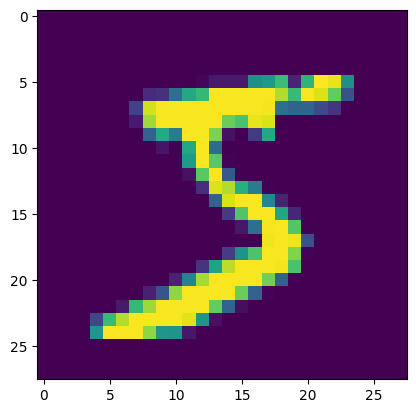

0


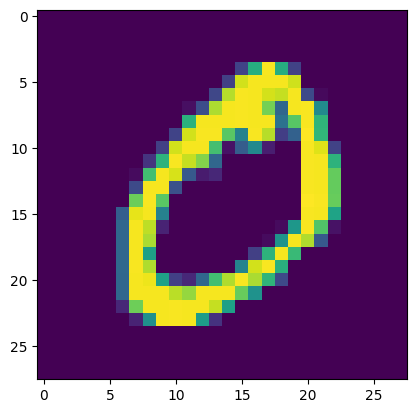

4


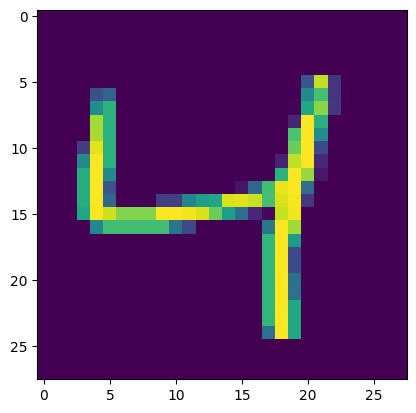

1


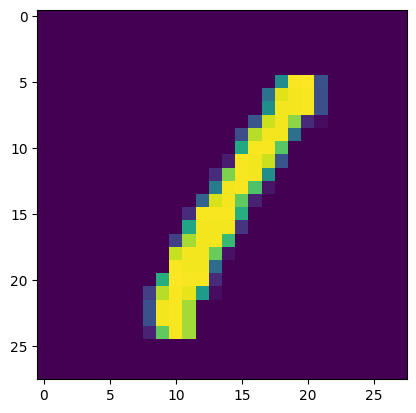

9


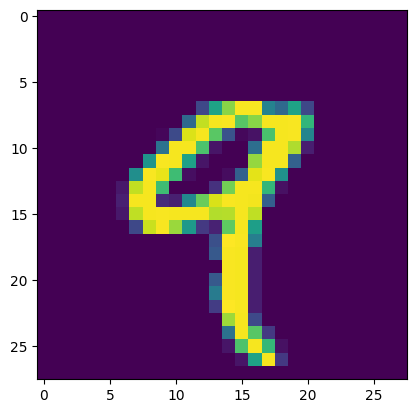

In [36]:
# Explore data
show5(image_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [37]:
class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28,128)
        self.fc2 = nn.Linear(128,64)
        self.output_layer = nn.Linear(64,10)
        self.hidden_activation = F.relu
        self.output_activation = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = torch.flatten(x,1)
        x = self.hidden_activation(self.fc1(x))
        x = self.hidden_activation(self.fc2(x))
        x = self.output_activation(self.output_layer(x))
        return x
        
        

In [38]:
model = MyNetwork()

I'm saving the initial state of my model so I can reload it when hyperparameter tuning.

In [39]:
initial_state = copy.deepcopy(model.state_dict())

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [40]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

I created a function for training the network as I will need to rerun this same code when tuning hyperparameters.

In [41]:
def training_loop(model, optimizer, criterion, training_dataloader, validation_dataloader, epochs=20, print_results=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    training_loss = []
    validation_loss = []
    for epoch in range(1,epochs+1):
        model.train()
        running_training_loss = 0
        running_validation_loss = 0
        running_training_accuracy = 0
        running_validation_accuracy = 0 
        for x, y in training_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat,y)
            running_training_loss += loss.item()
            running_training_accuracy += 1*(y==torch.argmax(yhat, dim=1)).sum().item()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for x, y in validation_dataloader:
                x = x.to(device)
                y = y.to(device)
                yhat = model(x)
                loss = criterion(yhat,y)
                running_validation_loss += loss.item()
                running_validation_accuracy += 1*(y==torch.argmax(yhat, dim=1)).sum().item()

        running_training_loss/=len(training_dataloader)
        running_validation_loss/=len(validation_dataloader)
        running_training_accuracy/=len(training_dataloader)
        running_validation_accuracy/=len(validation_dataloader)
        
        training_loss.append(running_training_loss)
        validation_loss.append(running_validation_loss)
        if print_results and epoch % 5 == 0:
            print(f"epoch {epoch}:\n----------\ntraining loss {running_training_loss}, validation loss {running_validation_loss}")
            print(f"training accuracy {running_training_accuracy}%, validation accuracy {running_validation_accuracy}%")
            print("==========")

    return model, training_loss, validation_loss

In [42]:
model, training_loss, validation_loss = training_loop(model, optimizer, criterion, training_dataloader, validation_dataloader)

epoch 5:
----------
training loss 0.18652840097993612, validation loss 0.18710535114631058
training accuracy 94.582%, validation accuracy 94.76%
epoch 10:
----------
training loss 0.16689740634150804, validation loss 0.2245959828980267
training accuracy 95.364%, validation accuracy 94.2%
epoch 15:
----------
training loss 0.1424574016323313, validation loss 0.17927026879042388
training accuracy 96.078%, validation accuracy 95.36%
epoch 20:
----------
training loss 0.14255477313511072, validation loss 0.2486201149970293
training accuracy 96.132%, validation accuracy 94.45%


Plot the training loss (and validation loss/accuracy, if recorded).

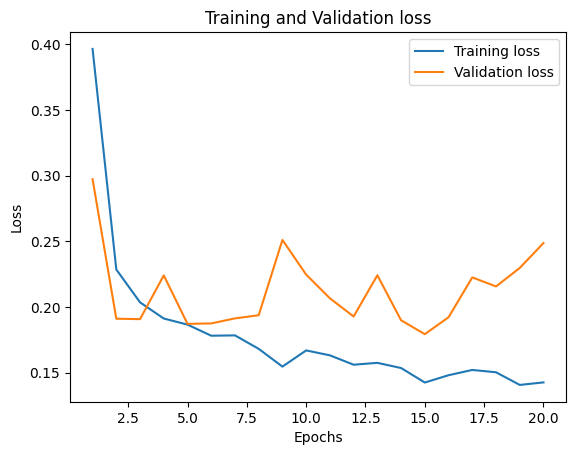

In [43]:
fig, ax = plt.subplots()
line1 = ax.plot(list(range(1,len(training_loss)+1)),training_loss, label='Training loss')
line2 = ax.plot(list(range(1,len(validation_loss)+1)),validation_loss, label='Validation loss')
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

The training loss looks a little jerky.  I might want to reduce the learning rate to smooth it out.  This will be the first hyperparameter I willl tune.  But first I will use the test set to check accuracy

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [44]:
test_accuracy = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    for x, y in test_dataloader:
        x.to(device)
        y.to(device)
        yhat = model(x)
        test_accuracy += 1*(y==torch.argmax(yhat, dim=1)).sum().item()
test_accuracy /= len(test_dataloader)
print(f"The accuracy on the test set is {test_accuracy}%")

The accuracy on the test set is 94.66%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

As the training loss graph looks jerky I want to reduce my learning rate to try and smooth it out, I will try a learning rate of 0.005 as well as 0.001

In [45]:
training_losses = []
validation_losses = []
model_parameters = []

for lr in [0.005, 0.001]:
    model.load_state_dict(initial_state)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model, training_loss, validation_loss = training_loop(model, optimizer, criterion, training_dataloader, validation_dataloader, print_results=False)
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)
    model_parameters.append(copy.deepcopy(model.state_dict()))

Now I want to compare the graphs

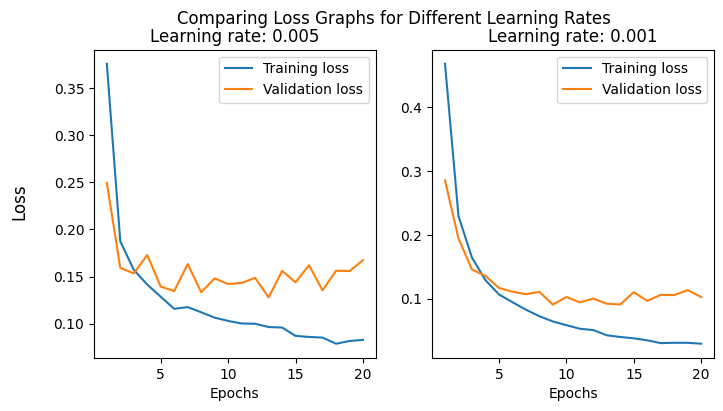

In [49]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
epochs = list(range(1,21))
axs[0].plot(epochs, training_losses[0], label="Training loss")
axs[0].plot(epochs, validation_losses[0], label="Validation loss")
axs[0].set_title("Learning rate: 0.005")
axs[0].set_xlabel('Epochs')
axs[0].legend()
axs[1].set_title("Learning rate: 0.001")
axs[1].plot(epochs, training_losses[1], label="Training loss")
axs[1].plot(epochs, validation_losses[1], label="Validation loss")
axs[1].set_xlabel('Epochs')
axs[1].legend()
fig.supylabel("Loss")
fig.suptitle("Comparing Loss Graphs for Different Learning Rates")
plt.show()

The learning rate of 0.001 appears to have the best behavior as both the training loss and validation loss curves are smoother.

Now I want to use this model on the test set

In [50]:
model.load_state_dict(model_parameters[1])

<All keys matched successfully>

In [51]:
test_accuracy = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    for x, y in test_dataloader:
        x.to(device)
        y.to(device)
        yhat = model(x)
        test_accuracy += 1*(y==torch.argmax(yhat, dim=1)).sum().item()
test_accuracy /= len(test_dataloader)
print(f"The accuracy on the test set is {test_accuracy}%")

The accuracy on the test set is 97.54%


The model has definitely imporved with test accuracy increasing from 94.66% to 97.54%

An option for the future is to enable early stopping as from the training and validation loss graphs it looks like loss for the validation set bottoms out around epoch 10.  But for now, I'm saving the model

## Saving your model
Using `torch.save`, save your model for future loading.

In [49]:
## YOUR CODE HERE ##